In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel

In [4]:
#Reading data from SQL database
connection = sqlite3.connect("kinara_assessment_20190807.db")
data_raw = pd.read_sql_query("SELECT DISTINCT loan.*, ent.business_type, ent.business_activity, ent.business_sector, score.ManagAgeui_APP, score.BusinFormalityOfTheBusinessui ,score.ManagCBscoreui_APP, dis.total_disbursement_amount, dis.disbursement_month from loan_information as loan left join enterprise_information as ent on loan.enterprise_id=ent.enterprise_id left join scores_information as score on loan.loan_id=score.loan_id left join (SELECT * from disbursement_information where account_number is not NULL) as dis on loan.account_number=dis.account_number", connection)

print('Output 1: Row & Column',data_raw.shape,'\n')
print('Output 2: Data Type:','\n',data_raw.dtypes,'\n')

data_raw.describe()
data_raw.head()

Output 1: Row & Column (2476, 15) 

Output 2: Data Type: 
 loan_id                            int64
account_number                    object
customer_id                        int64
enterprise_id                    float64
screening_date                    object
product_code                      object
hub_id                             int64
business_type                     object
business_activity                 object
business_sector                   object
ManagAgeui_APP                   float64
BusinFormalityOfTheBusinessui     object
ManagCBscoreui_APP               float64
total_disbursement_amount        float64
disbursement_month                object
dtype: object 



,loan_id,account_number,customer_id,enterprise_id,screening_date,product_code,hub_id,business_type,business_activity,business_sector,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP,total_disbursement_amount,disbursement_month
0,29321,None,71846,24500.0,2018-04-19,None,53,None,Job Work,Machine Components,27.0,None,776.0,NaN,None
1,13613,TLWCU0003070,31083,10723.0,2017-08-10,TLWCU,39,Trading,Retail,Electronics,30.0,Invoice & Banked,616.0,400000.0,Aug-2017
2,13921,None,31928,11002.0,2017-08-17,None,56,None,Retail,Agriculture,55.0,None,793.0,NaN,None
3,16520,None,38660,13220.0,2017-10-21,None,58,None,Retail,Food & Beverage,26.0,None,781.0,NaN,None
4,49742,TLWCS0012623,119694,40426.0,2018-12-24,TLWCS,27,Manufacturing,Job Work & Sales,Textiles,30.0,Cash & Non Banked,689.0,500000.0,Jan-2019


       ManagCBscoreui_APP
count         2473.000000
mean           594.897291
std            289.479152
min              0.000000
25%            556.000000
50%            733.000000
75%            793.000000
max            840.000000


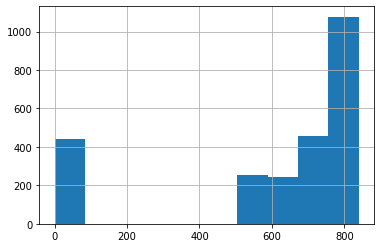

In [5]:
# Feature Engineering

data=data_raw

# flag whether loan appication was rejected or accepted
data['Loan_Accepted']=np.where(data['account_number'].isna()==True, 0,1) 

data['Secured_Loan']=data[['product_code']].apply(lambda x: x.str[-1], axis=1)

# Creating Cibil scores bucket by looking at distribution and based on business sense (-1:no info, 0:<6 months, 650+ is considered good)
data['ManagCBscoreui_APP'].hist()
print(data[['ManagCBscoreui_APP']].describe())

def cibil_condition(temp):
    if temp['ManagCBscoreui_APP']==-1:
        return 'No info'
    elif temp['ManagCBscoreui_APP']==0:
        return '<6 mths'
    elif temp['ManagCBscoreui_APP']>0 and temp['ManagCBscoreui_APP'] < 650:
        return 'bad score'
    elif temp['ManagCBscoreui_APP']>=650:
        return 'good score'
    else:
        return 'missing'

data['Cibil_Bucket']=data[['ManagCBscoreui_APP']].apply(cibil_condition, axis=1)

In [6]:
# Business Objective: To predict the likelihood of loan acceptance for a customer

# Variable catagorization
    # ID variables (can't be used in modeling): loan_id, account_number, customer_id, enterprise_id
    # Post term variable (can't be used in modeling): total_disbursement_amount, disbursement_month, product_code 
    # Variables to be used in modeling: ManagAgeui_APP, screening_date, BusinFormalityOfTheBusinessui, ManagCBscoreui_APP, business_sector, business_type, business_activity
    # Other variable (meaning is not known but it can be used in modeling): hub_id

Output 1: Missing values in Overall data: 
 loan_id                             0
account_number                   1107
customer_id                         0
enterprise_id                       1
screening_date                    126
product_code                     1058
hub_id                              0
business_type                     464
business_activity                   1
business_sector                     1
ManagAgeui_APP                      3
BusinFormalityOfTheBusinessui     488
ManagCBscoreui_APP                  3
total_disbursement_amount        1107
disbursement_month               1107
Loan_Accepted                       0
Secured_Loan                     1058
Cibil_Bucket                        0
dtype: int64 

Output 2: Missing values in Accepted Loan: 
 loan_id                            0
account_number                     0
customer_id                        0
enterprise_id                      1
screening_date                   126
product_code               

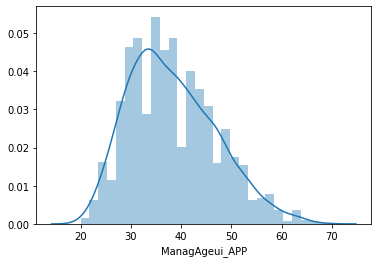

In [7]:
#  Missing values check and value imputation
print('Output 1: Missing values in Overall data:','\n',data.isna().sum(),'\n')
print('Output 2: Missing values in Accepted Loan:','\n',data[data['Loan_Accepted']==1].isna().sum(),'\n')
  
# Checking variable distribution to decide mean/median imputation (ploting for ManagAgeui_APP only)  
sns.distplot(data['ManagAgeui_APP'])

# Imputing following variables with mean
    # Mean: ManagAgeui_APP
data['ManagAgeui_APP'].fillna(data['ManagAgeui_APP'].mean(), inplace=True)

# Imputing following variables with median
    # Median: ManagCBscoreui_APP
data['ManagCBscoreui_APP'].fillna(data['ManagCBscoreui_APP'].median(), inplace=True)


# No imputation is required for the below variables as missing values are there for Rejected loan only; Accepted loans have values populated
    # total_disbursement_amount, disbursement_month

# No imputation for ID and date columns
    # loan_id, loan_id, account_number, customer_id, enterprise_id, screening_date

    
# Imputing with adding 'missing' in the columns
    # product_code, business_type, business_activity, business_sector, BusinFormalityOfTheBusinessui, Secured_Loan
data['product_code'].fillna('Missing', inplace=True)
data['business_type'].fillna('Missing', inplace=True)
data['business_activity'].fillna('Missing', inplace=True)
data['business_sector'].fillna('Missing', inplace=True)
data['BusinFormalityOfTheBusinessui'].fillna('Missing', inplace=True)
data['Secured_Loan'].fillna('Missing', inplace=True)

print('Output 3: Missing values after treatment:','\n',data.isna().sum(),'\n')


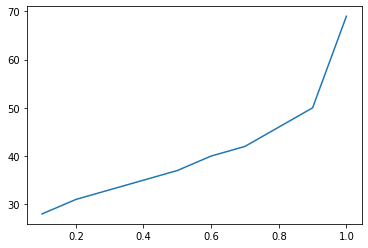

In [8]:
# Variable distribution for numerical variables

#Distribution check of numeric variables
# sns.distplot(data['ManagAgeui_APP'])

#Percentile plot of numerical variables
def percentile_plot(variable):
    a=[i/10 for i in list(range(1,11))]
    plt.plot(data[[variable]].apply(lambda x: x.quantile(a)))

percentile_plot('ManagAgeui_APP')
# percentile_plot('ManagCBscoreui_APP')
# percentile_plot('total_disbursement_amount')

No of unique values: 5


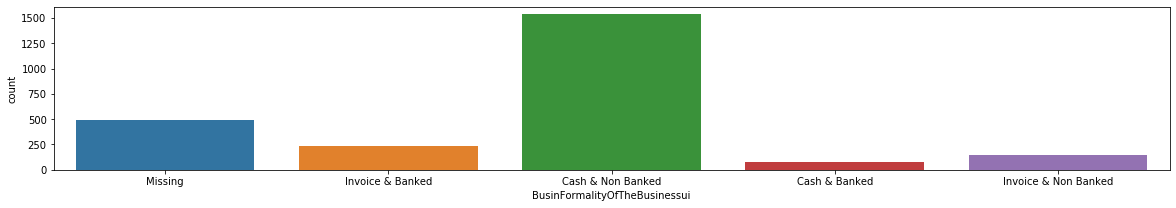

In [9]:
#Histogram check for categorical variables
def Histogram_plot(variable):
    print('No of unique values:',data[variable].nunique())
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.countplot(data[variable])
    
Histogram_plot('BusinFormalityOfTheBusinessui')
# Histogram_plot('business_type')
# Histogram_plot('business_activity')
# Histogram_plot('business_sector')


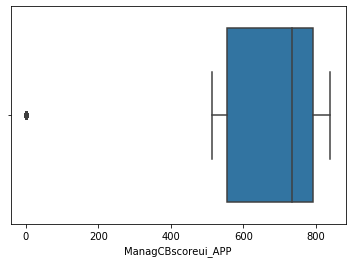

In [10]:
# Outlier check (numerical var only)
# sns.boxplot(data['ManagAgeui_APP'])  # Age: There are some variables outside of IQR but it is in acceptable range 
# sns.boxplot(data[data['Loan_Accepted']==1]['total_disbursement_amount'])  # Loan Amt: There are some values outside of IQR but it's in acceptable range
sns.boxplot(data['ManagCBscoreui_APP'])  # Cibil Score: There are some values outside of IQR but there is a meaning for 0 value 


Variable: business_activity 
                                sum  count        RR
business_activity                                  
Job Work                       187    322  0.580745
Job Work & Sales               252    482  0.522822
Job Work and sales               4      4  1.000000
Missing                          1      1  1.000000
Retail                         364    744  0.489247
Retail (Business to Business)    3      4  0.750000
Retail (Business to Customer)    2      5  0.400000
Sales                          360    549  0.655738
Whole Sale                     195    364  0.535714
Whole sale                       1      1  1.000000 



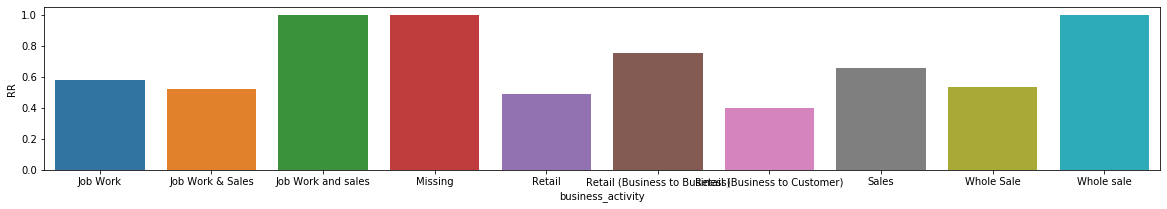

In [11]:
# Bi-variate analysis (char variables)

# Response rate by categories 
def RR_category(col):
    RR_temp = data.groupby(col)['Loan_Accepted'].agg(['sum','count'])
    RR_temp['RR']=RR_temp['sum']/RR_temp['count']
    print('Variable:',col,'\n',RR_temp,'\n')
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.barplot(y=RR_temp['RR'], x=RR_temp.index)

# RR_category('Cibil_Bucket')

# RR_category('BusinFormalityOfTheBusinessui')
# RR_category('Secured_Loan')
# RR_category('business_type')
RR_category('business_activity')
# RR_category('business_sector')

Portfolio RR: 0.552907915993538 

Variable: ManagAgeui_APP 
               Var  sum  count        RR
Decile                                 
0       25.921502  158    293  0.539249
1       30.013115  175    305  0.573770
2       32.538793  132    232  0.568966
3       34.434043  138    235  0.587234
4       36.436548  113    197  0.573604
5       38.936195  174    301  0.578073
6       41.537572   92    173  0.531792
7       44.449477  160    287  0.557491
8       48.235849  112    212  0.528302
9       55.132780  115    241  0.477178 

Variable: ManagCBscoreui_APP 
                Var  sum  count        RR
Decile                                  
0        59.442000  277    500  0.554000
1       561.600806   68    248  0.274194
2       647.309237  115    249  0.461847
3       711.018382  134    272  0.492647
4       752.135246  153    244  0.627049
5       771.591111  137    225  0.608889
6       790.456000  152    250  0.608000
7       802.891667  159    240  0.662500
8       816.0000

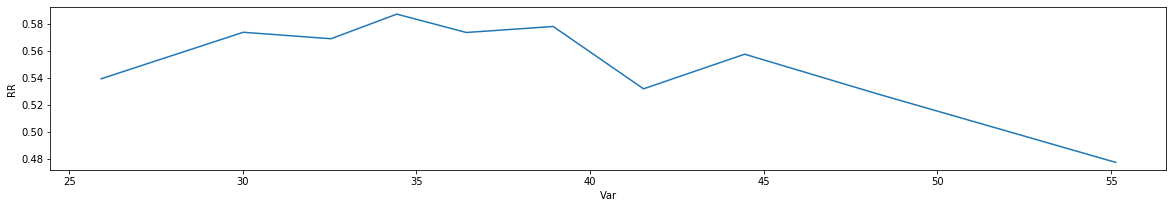

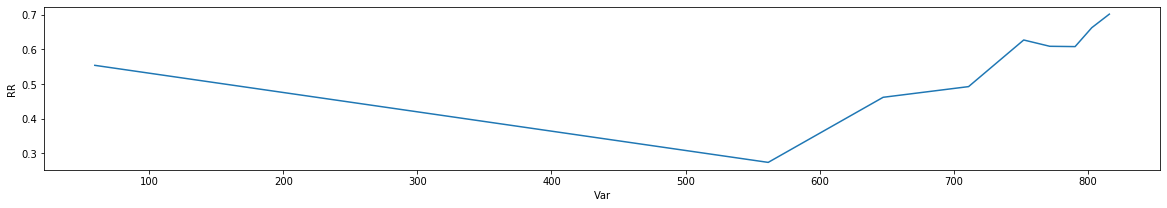

In [12]:
# Bi-variate analysis (numeric variables)

print('Portfolio RR:',data['Loan_Accepted'].sum()/len(data),'\n')
def Decile_RR(variable):
    Decile_temp=data
    Decile_temp['Decile'] = pd.qcut(Decile_temp[variable], 10,labels = False, duplicates='drop') 

    RR_temp = Decile_temp.groupby('Decile').agg({variable:['mean'], 'Loan_Accepted':['sum','count']})
    RR_temp.columns=['Var','sum','count']
    RR_temp['RR']=RR_temp['sum']/RR_temp['count']
    print('Variable:',variable,'\n',RR_temp,'\n')
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(y=RR_temp['RR'], x=RR_temp['Var'])

Decile_RR('ManagAgeui_APP')
Decile_RR('ManagCBscoreui_APP')


In [13]:
# Feature Engineering: Creating variables for customers who have applied for repeat loans

print('Total Loan Application:',data['enterprise_id'].nunique(),'\n','# unique enterprise',len(data),'\n',
      'Repeat loan application',len(data) - data['enterprise_id'].nunique())

data['Previous_application']=0
data['Previous_accepted_application']=0
data['Previous_rejected_application']=0
data['Previous_Cibil_avg']=0
data['Previous_Cibil_max']=0
data['Previous_Cibil_min']=0
data['Previous_Secured_Loan']=0
data['Previous_Unsecured_Loan']=0

for i in data['enterprise_id'].unique():
    temp_data=data[data['enterprise_id']==i]
    if len(temp_data)>1:
        temp_data.sort_values(by='screening_date', ascending=True)
        temp_index = temp_data.index
        for j in range(0,len(temp_data)):

            #No of previous loan application
            data.loc[temp_index[j],'Previous_application']=len(temp_data)-j-1

            #No of previous accepted application
            data.loc[temp_index[j],'Previous_accepted_application']=temp_data.iloc[j+1:]['Loan_Accepted'].sum()

            #No of previous rejected application
            data.loc[temp_index[j],'Previous_rejected_application']=(len(temp_data)-j-1) - (temp_data.iloc[j+1:]['Loan_Accepted'].sum())

            #Avg Cibil score previously
            data.loc[temp_index[j],'Previous_Cibil_avg']=temp_data.iloc[j+1:,]['ManagCBscoreui_APP'].mean()

            #Max Cibil score previously
            data.loc[temp_index[j],'Previous_Cibil_max']=temp_data.iloc[j+1:,]['ManagCBscoreui_APP'].max()

            #Min Cibil score previously
            data.loc[temp_index[j],'Previous_Cibil_max']=temp_data.iloc[j+1:,]['ManagCBscoreui_APP'].min()

            # Number of Secured loan previously
            data.loc[temp_index[j],'Previous_Secured_Loan']=len(temp_data.iloc[j+1:,][temp_data.iloc[j+1:,]['Secured_Loan']=='S']['Secured_Loan'])

            # Number of Unsecured loan previously
            data.loc[temp_index[j],'Previous_Unsecured_Loan']=len(temp_data.iloc[j+1:,][temp_data.iloc[j+1:,]['Secured_Loan']=='U']['Secured_Loan'])

data['Previous_Cibil_avg'].fillna(0, inplace=True)
data['Previous_Cibil_min'].fillna(0, inplace=True)
data['Previous_Cibil_max'].fillna(0, inplace=True)

Total Loan Application: 2442 
 # unique enterprise 2476 
 Repeat loan application 34


In [14]:
# Information Value
data_IV=data

def IV_categorical(col, col_type):
    if col_type=='char':
        IV_temp = data.groupby(col)['Loan_Accepted'].agg(['sum','count'])
    elif col_type=='num':
        data_IV['Decile'] = pd.qcut(data_IV['ManagCBscoreui_APP'], 10,labels = False, duplicates='drop') 
        IV_temp = data.groupby('Decile')['Loan_Accepted'].agg(['sum','count'])
    
    IV_temp['Goods']=IV_temp['sum']
    IV_temp['Bad']=(IV_temp['count']-IV_temp['sum'])
    IV_temp['percent_Goods']=IV_temp['Goods']/IV_temp['Goods'].sum()
    IV_temp['percent_Bads']=IV_temp['Bad']/IV_temp['Bad'].sum()
    IV_temp['IV']=np.log(IV_temp['percent_Goods']/IV_temp['percent_Bads'])*(IV_temp['percent_Goods'] - IV_temp['percent_Bads'])
    print('Variable:',col,IV_temp['IV'].sum(), '\n')

IV_categorical('Cibil_Bucket','char')
IV_categorical('hub_id','char')
IV_categorical('ManagCBscoreui_APP','num')
IV_categorical('ManagAgeui_APP','num')

IV_categorical('Previous_application','char')
IV_categorical('Previous_accepted_application','char')
IV_categorical('Previous_rejected_application','char')
IV_categorical('Previous_Cibil_min','char')
IV_categorical('Previous_Unsecured_Loan','char')


Variable: Cibil_Bucket 0.2517446792656204 

Variable: hub_id 0.22324275834414395 

Variable: ManagCBscoreui_APP 0.23141854165769876 

Variable: ManagAgeui_APP 0.23141854165769876 

Variable: Previous_application 0.008103123336974936 

Variable: Previous_accepted_application 0.010255161330866585 

Variable: Previous_rejected_application 1.598506675825027e-05 

Variable: Previous_Cibil_min 0.0 

Variable: Previous_Unsecured_Loan 0.013455354577976083 



In [15]:
# One hot encoding

# Passing hub_id as charater in model
data_model=data

data_model['hub_id']=data_model['hub_id'].astype(str)

data_model=pd.concat([data_model, pd.get_dummies(data_model['Secured_Loan'],drop_first=True, prefix='Secured')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Cibil_Bucket'],drop_first=True, prefix='Cibil')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['hub_id'],drop_first=True, prefix='Hub')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['product_code'],drop_first=True, prefix='Product')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['business_type'],drop_first=True, prefix='Business_T')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['business_sector'],drop_first=True, prefix='Business_S')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['business_activity'],drop_first=True, prefix='Business_A')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['BusinFormalityOfTheBusinessui'],drop_first=True, prefix='Business_F')], axis=1)


data_model.drop('Secured_Loan', axis=1, inplace=True)
data_model.drop('Cibil_Bucket', axis=1, inplace=True)
data_model.drop('hub_id', axis=1, inplace=True)
data_model.drop('product_code', axis=1, inplace=True)
data_model.drop('business_type', axis=1, inplace=True)
data_model.drop('business_sector', axis=1, inplace=True)
data_model.drop('business_activity', axis=1, inplace=True)
data_model.drop('BusinFormalityOfTheBusinessui', axis=1, inplace=True)

# pd.DataFrame(data_model.dtypes).to_csv('Model_variables.csv')

In [20]:
# Split the data into training and testing sets

# (Assumption: Secured Loan variable can be used in model as when a new customer applies for a laon, all the details (what type of loan- Secured/Unsecured) are taken from the customer)


X=data_model[['ManagAgeui_APP',	'ManagCBscoreui_APP',	'Previous_application',	'Previous_accepted_application',	'Previous_rejected_application',	'Previous_Cibil_avg',	'Previous_Cibil_max',	'Previous_Cibil_min',	'Previous_Secured_Loan',	'Previous_Unsecured_Loan',	'Secured_S',	'Secured_U',	'Cibil_bad score',	'Cibil_good score',	'Cibil_missing',	'Product_ICWCS',	'Product_ICWCU',	'Product_LCRDS',	'Product_LCRDU',	'Product_LCRIS',	'Product_LCRIU',	'Product_Missing',	'Product_STWCS',	'Product_STWCU',	'Product_TLAPS',	'Product_TLBDS',	'Product_TLBDU',	'Product_TLMFS',	'Product_TLWCS',	'Product_TLWCU',	'Product_VCWCS',	'Business_T_Missing',	'Business_T_Services',	'Business_T_Trading',	'Business_S_Apparel',	'Business_S_Auto Components',	'Business_S_Automobiles',	'Business_S_Bedding',	'Business_S_Bedding Industry',	'Business_S_Book Stores',	'Business_S_Chemicals',	'Business_S_Construction',	'Business_S_Construction Material',	'Business_S_Electrical',	'Business_S_Electricals',	'Business_S_Electronics',	'Business_S_Fabrication',	'Business_S_Fashion',	'Business_S_Food & Beverage',	'Business_S_Food Products',	'Business_S_Furniture',	'Business_S_General',	'Business_S_Handicrafts',	'Business_S_Health & Beauty',	'Business_S_Hobbies',	'Business_S_Home Care',	'Business_S_Home Furnishings',	'Business_S_Houseware',	'Business_S_Industrial',	'Business_S_Leather',	'Business_S_Machine  Components',	'Business_S_Machine Components',	'Business_S_Medical Equipment',	'Business_S_Metal works',	'Business_S_Missing',	'Business_S_Paper',	'Business_S_Pharmaceuticals',	'Business_S_Plastics',	'Business_S_Printing',	'Business_S_Rubber',	'Business_S_Textiles',	'Business_S_Wood',	'Business_A_Job Work & Sales',	'Business_A_Job Work and sales',	'Business_A_Missing',	'Business_A_Retail',	'Business_A_Retail (Business to Business)',	'Business_A_Retail (Business to Customer)',	'Business_A_Sales',	'Business_A_Whole Sale',	'Business_A_Whole sale',	'Business_F_Cash & Non Banked',	'Business_F_Invoice & Banked',	'Business_F_Invoice & Non Banked',	'Business_F_Missing']]
y=data_model['Loan_Accepted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Training (Row, Columns):', X_train.shape, y_train.shape)
print('Testing (Row, Columns):', X_test.shape, y_test.shape)


Training (Row, Columns): (1980, 85) (1980,)
Testing (Row, Columns): (496, 85) (496,)


In [21]:
RF = RandomForestRegressor(n_estimators = 50, random_state = 11)

# Train the model on training dataset
RF.fit(X_train, y_train)
Predict=RF.predict(X_test)
print(classification_report(y_test,Predict.round()))
print("ROC Score:", roc_auc_score(y_test, Predict))

# Model performance is coming very high because Secured Loan
# (Assumption: It can be used in model as when a new customer applies for a laon, all the details (what type of loan- Secured/Unsecured) are taken from the customer)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       225
           1       0.99      1.00      0.99       271

    accuracy                           0.99       496
   macro avg       0.99      0.99      0.99       496
weighted avg       0.99      0.99      0.99       496

ROC Score: 0.9905371053710537


In [22]:
# Top features
feature_importances = pd.DataFrame(RF.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance',  ascending=False)
feature_importances.head(10)

,importance
Product_Missing,0.922286
Business_T_Missing,0.029467
ManagAgeui_APP,0.013769
ManagCBscoreui_APP,0.010138
Product_TLAPS,0.001689
Business_S_Bedding,0.001610
Product_ICWCU,0.001401
Previous_Cibil_max,0.001279
Business_S_Fabrication,0.001269
Business_A_Job Work & Sales,0.001243
